# World Data League 2022

## 🎯 Challenge
*Air Quality Prediction in Busy Streets*


## 👥 Authors
* TinWan Ng
* Fernando Chavez

## 💻 Development

### Import modules 

In [65]:
# Data Processing
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import scipy.stats as stats
import pylab
from IPython.display import Image

import statsmodels.tsa.stattools as statstool

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as tsaplots

#!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import StepwiseContext

from scipy.stats import chi2
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!pip install xgboost
from xgboost import XGBRegressor

# Cleaning

In this section the air quality data and the weather data were both cleaned.

## Cleaning Air Quality Data

### Read or open the CSV file

We started by importing our air quality csv file.

In [114]:
air_quality = pd.read_csv('air_quality.csv')

### Get dataset columns names 

Afterwards, we checked the column names to see if there were any unusual names.

In [115]:
air_quality.columns

Index(['Unnamed: 0', 'id', 'component_id', 'value', 'timestamp_measured'], dtype='object')

### Drop unnecesary column

There was a column that had to be deleted because it only contained enumeration of the rows, which in this case is irrelevant since the Pandas Dataframe already contains an index column by default with these same values.

In [116]:
air_quality = air_quality.drop(['Unnamed: 0'], axis=1)

### Rename Column Names

We rename some of the column names to have a better understanding when referring at them in the future.

In [117]:
air_quality = air_quality.rename(columns={
                                "component_id":"pollutant_type",
                                "value":"measured_value",
                                "timestamp_measured":"date_time"})

### Get info on the data types of the dataframe

Next, we looked into the data types of the columns in case a column had a wrong data type. 

In [118]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548357 entries, 0 to 548356
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              548357 non-null  object 
 1   pollutant_type  537177 non-null  object 
 2   measured_value  548357 non-null  float64
 3   date_time       548357 non-null  object 
dtypes: float64(1), object(3)
memory usage: 16.7+ MB


### Change ```timestamp_measured``` column from a string data type to a timestamp data type

The column "timestamp_measured" had a "String" or Text data type and had to be changed into a datetime type so that we could process the dates.

In [119]:
air_quality['date_time'] = pd.to_datetime(air_quality.date_time)

### Check if the ID values are all unique

We noticed that the "id" column values were not unique which means there were duplicated rows.

In [120]:
air_quality['id'].is_unique

False

In [121]:
air_quality['id'].value_counts()

59632e0f-3090-417c-900c-a03983f7e2cf    2
c4946fc6-5892-46b3-9c08-ea4f8acf3032    2
1afce3d9-3504-4432-9fb1-4d458254e416    2
d30bfd43-6659-477d-8dbe-ae3b10831f00    2
7ddb08b2-4ff1-43f7-85c2-8b53f191537e    2
                                       ..
7349b3f7-cf0e-40e2-88ae-d84495ac2fa4    1
2b5b5cd4-9765-46db-bcd1-2ab77c60e40a    1
af0d327e-96ae-44f6-95a3-73906147381d    1
5e0a99c1-56dc-427f-ae30-94dda1089630    1
2c504ca6-4a1b-40e2-b589-a9535eb889b6    1
Name: id, Length: 548165, dtype: int64

### Count Duplicate Rows

After, we saw that there were 192 duplicated rows which means the id values were repeated.

In [122]:
air_quality.duplicated().sum()

192

### Drop Rows with ID Duplicates

We decided to delete all the repeated rows.

In [123]:
air_quality = air_quality.drop_duplicates()

### Check for Null Values

Afterwards, we checked for the amount of null values in every column. We saw that the "component_id" column had 11,180 missing values which means some rows did not have the pollutant name in them.

In [124]:
air_quality.isnull().sum()

id                    0
pollutant_type    11180
measured_value        0
date_time             0
dtype: int64

### Drop rows with null ```component_id``` names

We decided to delete all the rows that did not have a pollutant type name in them since it would have been too much time consuming to find the name of the pollutant based on its measurement or measured value.

In [125]:
air_quality = air_quality.dropna()

### Check if there are values below 0

Next, we checked if the column "value" had measured values below 0 and we found 1870 values with a negative value.

In [126]:
air_quality[air_quality['measured_value'] < 0].shape[0]

1870

### Keep rows with measured values above 0

We decided to keep the values above 0.

In [127]:
air_quality = air_quality[air_quality['measured_value'] > 0]

## Cleaning Amsterdam Weather Data

### Import AMS Weather Data

We imported the csv file which included the Amsterdam weather data

In [68]:
weather = pd.read_csv('weather_ams.csv')

### General Info about the dataset

We took a look into the data types of the columns. We saw that the date column had a "String" or Text type and for that reason the data type was changed to datetime so that we could process the dates. 

In [69]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2968 non-null   object 
 1   tavg    2941 non-null   float64
 2   tmin    2941 non-null   float64
 3   tmax    2941 non-null   float64
 4   prcp    1382 non-null   float64
 5   snow    0 non-null      float64
 6   wdir    2760 non-null   float64
 7   wspd    2833 non-null   float64
 8   wpgt    1303 non-null   float64
 9   pres    2891 non-null   float64
 10  tsun    0 non-null      float64
dtypes: float64(10), object(1)
memory usage: 255.2+ KB


In [70]:
weather['date'] = pd.to_datetime(weather.date)

### Change Column Names

We changed some of the column names to have a better understanding when refering at them.

In [71]:
weather = weather.rename(columns={

                                "tavg":"avg_temperature",
                                "tmax":"max_temperature",
                                "tmin":"min_temperature",
                                "prcp":"precipitation", 
                                "wdir":"wind_direction", 
                                "wspd":"wind_speed",
                                "wpgt":"wind_peak_gust", 
                                "pres":"pressure",
                                "tsun":"sunshine_time"})

### Descriptive stats of the dataset's values

Next, we took a look into the distribution of the values per column. 

In [72]:
weather.describe()

,avg_temperature,min_temperature,max_temperature,precipitation,snow,wind_direction,wind_speed,wind_peak_gust,pressure,sunshine_time
count,2941.000000,2941.000000,2941.000000,1382.000000,0.0,2760.000000,2833.000000,1303.000000,2891.000000,0.0
mean,11.098028,7.719143,14.441448,2.263459,NaN,192.167754,17.782527,41.749194,1015.272501,NaN
std,5.868980,5.518835,6.661504,4.504545,NaN,88.970246,7.838343,15.241752,10.035567,NaN
min,-6.500000,-9.800000,-5.300000,0.000000,NaN,0.000000,4.000000,11.100000,975.300000,NaN
25%,6.500000,3.600000,9.100000,0.000000,NaN,131.000000,12.200000,31.500000,1009.350000,NaN
50%,10.800000,7.700000,14.100000,0.100000,NaN,206.000000,16.400000,40.000000,1016.000000,NaN
75%,15.900000,12.200000,19.700000,2.500000,NaN,252.000000,22.100000,50.000000,1021.950000,NaN
max,29.400000,23.400000,36.000000,47.700000,NaN,359.000000,51.600000,112.000000,1046.700000,NaN


### Drop 'snow' and 'tsun' because of no values in their columns

We found that two columns had no values at all, so we deleted those columns.

In [73]:
weather = weather.drop(['snow', 'sunshine_time'], axis=1)

### Count null values per column

Next, we checked the count of null values in each column.

In [74]:
weather.isnull().sum()

date                  0
avg_temperature      27
min_temperature      27
max_temperature      27
precipitation      1586
wind_direction      208
wind_speed          135
wind_peak_gust     1665
pressure             77
dtype: int64

We saw that some columns only had less than 300 missing values and because of this we decided to fill in the missing values of those columns with a 3 point rolling average. 

Everytime we did the rolling average, we would check how many null values got replaced since it was a 3 point rolling average.

### Fill Temperature Null Values With A 3 Point Rolling Average 

In [75]:
weather['avg_temperature'] = weather['avg_temperature'].fillna(weather['avg_temperature'].rolling(window=3, min_periods=1).mean())
weather['min_temperature'] = weather['min_temperature'].fillna(weather['min_temperature'].rolling(window=3, min_periods=1).mean())
weather['max_temperature'] = weather['max_temperature'].fillna(weather['max_temperature'].rolling(window=3, min_periods=1).mean())

In [76]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2968 non-null   datetime64[ns]
 1   avg_temperature  2968 non-null   float64       
 2   min_temperature  2968 non-null   float64       
 3   max_temperature  2968 non-null   float64       
 4   precipitation    1382 non-null   float64       
 5   wind_direction   2760 non-null   float64       
 6   wind_speed       2833 non-null   float64       
 7   wind_peak_gust   1303 non-null   float64       
 8   pressure         2891 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 208.8 KB


### Fill Wind direction and Wind Speed Null Values With A 3 Point Rolling Average 

In [77]:
weather['wind_direction'] = weather['wind_direction'].fillna(weather['wind_direction'].rolling(window=3, min_periods=1).mean())
weather['wind_speed'] = weather['wind_speed'].fillna(weather['wind_speed'].rolling(window=3, min_periods=1).mean())

In [78]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2968 non-null   datetime64[ns]
 1   avg_temperature  2968 non-null   float64       
 2   min_temperature  2968 non-null   float64       
 3   max_temperature  2968 non-null   float64       
 4   precipitation    1382 non-null   float64       
 5   wind_direction   2948 non-null   float64       
 6   wind_speed       2952 non-null   float64       
 7   wind_peak_gust   1303 non-null   float64       
 8   pressure         2891 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 208.8 KB


### Fill Pressure Null Values With A 3 Point Rolling Average

In [79]:
weather['pressure'] = weather['pressure'].fillna(weather['pressure'].rolling(window=3, min_periods=1).mean())

In [80]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2968 non-null   datetime64[ns]
 1   avg_temperature  2968 non-null   float64       
 2   min_temperature  2968 non-null   float64       
 3   max_temperature  2968 non-null   float64       
 4   precipitation    1382 non-null   float64       
 5   wind_direction   2948 non-null   float64       
 6   wind_speed       2952 non-null   float64       
 7   wind_peak_gust   1303 non-null   float64       
 8   pressure         2935 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 208.8 KB


### Select Average Temperature, Wind Direction and Speed, and Pressure columns as well as drop all rows with null values

Afterwards, we only kept the columns which null values were replaced ( except the minumum and maximum temperature) by the rolling average. We did not keep the precipitation and wind peak values because there were more than a 1000 missing values which would have made the analysis hard because there would be have been a big gap.

In [81]:
weather = weather[["date", "avg_temperature", "wind_direction", "wind_speed", "pressure"]]

In [82]:
weather = weather.dropna()

In [83]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 2967
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2929 non-null   datetime64[ns]
 1   avg_temperature  2929 non-null   float64       
 2   wind_direction   2929 non-null   float64       
 3   wind_speed       2929 non-null   float64       
 4   pressure         2929 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 137.3 KB


# Exploratory Data Analysis Air Quality Data

## Pivot the component_id values to columns

The air quality data had to be pivoted so that it could be used for the time series model. The columns would be the pollutants and the measurement date

In [128]:
pivot_air_quality = air_quality.pivot(index='date_time', columns='pollutant_type')['measured_value']

In [129]:
pivot_air_quality.head()

pollutant_type,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25
date_time,,,,,,,,
2014-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,27.0,43.0,NaN,NaN
2014-01-01 01:00:00+00:00,1.21,1.41,NaN,2.38,30.0,42.0,90.3,74.7
2014-01-01 02:00:00+00:00,0.97,1.65,NaN,2.55,28.0,50.0,97.3,84.0
2014-01-01 03:00:00+00:00,1.11,1.98,NaN,2.50,24.0,48.0,41.6,34.7
2014-01-01 04:00:00+00:00,1.04,2.31,NaN,2.18,19.0,45.0,28.1,20.6


In [130]:
pivot_air_quality = pivot_air_quality.reset_index()

When we pivot the air quality data, null values appeared since some dates or times did not have a measured value. To deal with that we decided to replace the null values with 0.

In [131]:
pivot_air_quality = pivot_air_quality.fillna(0)

## Normalisation of the data

The data was normalized so that it is more interpretable for the end user. We gather safe levels for each pollutant and we divided every value with its safe value. If the result values are over 1, it means they are above the safe level or that they are in a moderate level.

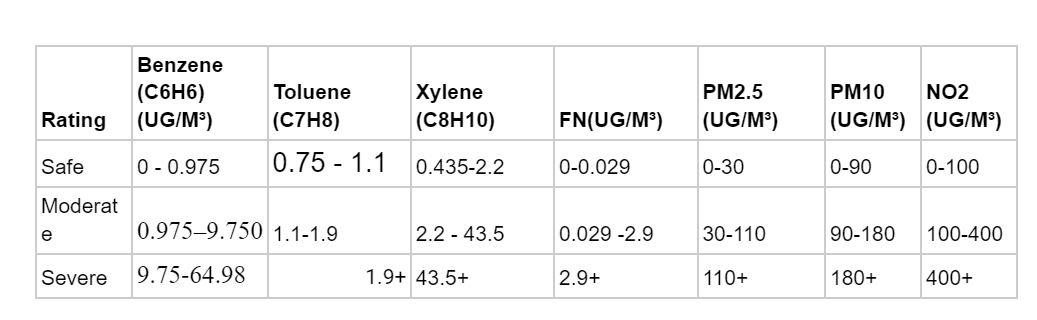

In [37]:
safe_level = {'C6H6': 0.975, 'C7H8': 1.1, 'C8H10': 2.2, 'FN': 0.029, 'NO': 100, 'NO2': 100, 'PM10': 90, 'PM25': 30}

normalized_df = pd.DataFrame({'date_time': pivot_air_quality.date_time,
                              'C6H6': round(pivot_air_quality.C6H6.div(0.975), 4), 
                              'C7H8': round(pivot_air_quality.C7H8.div(1.1), 4), 
                              'C8H10': round(pivot_air_quality.C8H10.div(2.2), 4), 
                              'FN': round(pivot_air_quality.FN.div(0.029), 4),
                              'NO': round(pivot_air_quality.NO.div(100), 4), 
                              'NO2': round(pivot_air_quality.NO2.div(100), 4), 
                              'PM10': round(pivot_air_quality.PM10.div(90), 4), 
                              'PM25': round(pivot_air_quality.PM25.div(30), 4)})

In [38]:
normalized_df.head()

,date_time,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25
0,2014-01-01 00:00:00+00:00,0.0000,0.0000,0.0,0.0000,0.27,0.43,0.0000,0.0000
1,2014-01-01 01:00:00+00:00,1.2410,1.2818,0.0,82.0690,0.30,0.42,1.0033,2.4900
2,2014-01-01 02:00:00+00:00,0.9949,1.5000,0.0,87.9310,0.28,0.50,1.0811,2.8000
3,2014-01-01 03:00:00+00:00,1.1385,1.8000,0.0,86.2069,0.24,0.48,0.4622,1.1567
4,2014-01-01 04:00:00+00:00,1.0667,2.1000,0.0,75.1724,0.19,0.45,0.3122,0.6867


We did box plots for the values of each pollutant

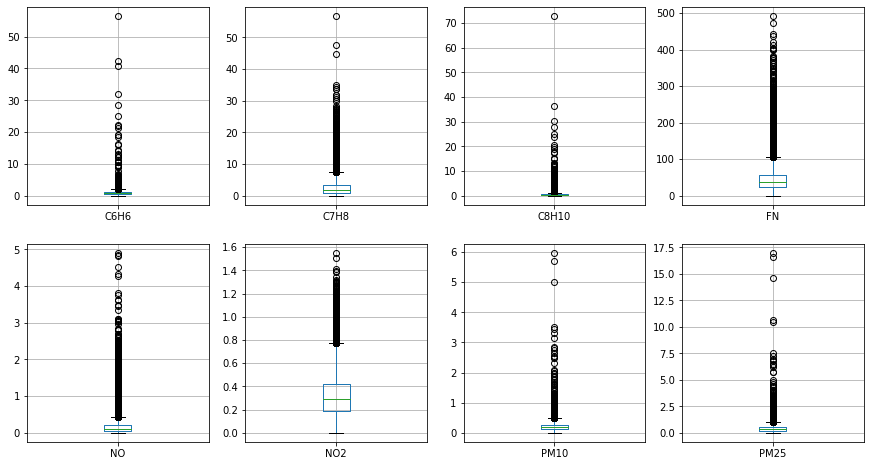

In [47]:

fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,8)) # create 2x2 array of subplots
normalized_df.boxplot(column='C6H6', ax=axes[0,0]) # add boxplot to 1st subplot
normalized_df.boxplot(column='C7H8', ax=axes[0,1]) # add boxplot to 2nd subplot
normalized_df.boxplot(column='C8H10', ax=axes[0,2]) # add boxplot to 2nd subplot
normalized_df.boxplot(column='FN', ax=axes[0,3]) # add boxplot to 2nd subplot
normalized_df.boxplot(column='NO', ax=axes[1,0]) # add boxplot to 2nd subplot
normalized_df.boxplot(column='NO2', ax=axes[1,1]) # add boxplot to 2nd subplot
normalized_df.boxplot(column='PM10', ax=axes[1,2]) # add boxplot to 2nd subplot
normalized_df.boxplot(column='PM25', ax=axes[1,3]) # add boxplot to 2nd subplot

plt.show()

Using the normalized data we created a dashboard in google data studio, to make the graphing more straightforward

We found out that most of the pollutants have been in a safe value. C7H8 have been above the safe value since 2014 but throughout the years the values have been decreasing and starting from 2022 the value started touching the safe zone. FN have been way off the safe leve, even above the moderate zone.


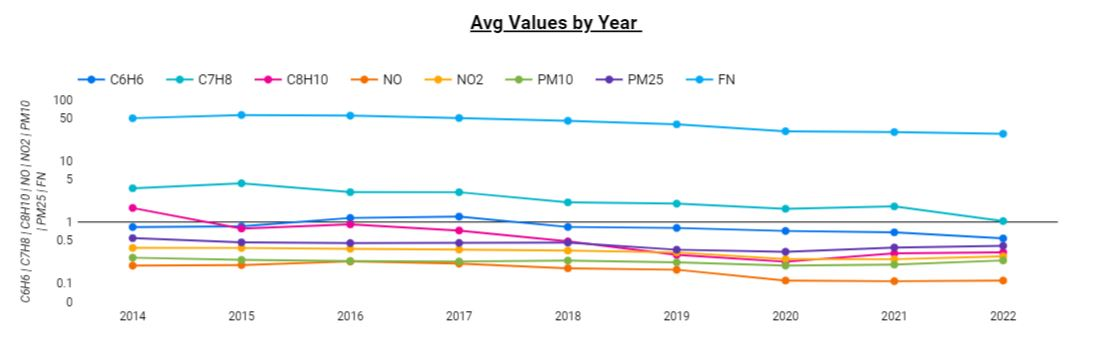

We can see that most of pollutant values decrease around the summer and start to increace around fall time up to the end of every year.

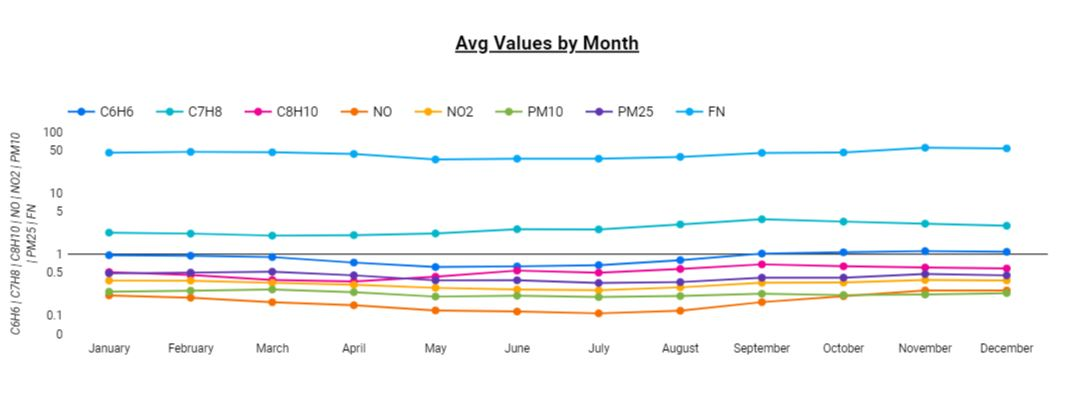

We also look at the pollutants values per each hour of the day. In this example we can see that for the NO2 values around the morning is the highest than it decreases and then it increases again as the afternoon aproaches.

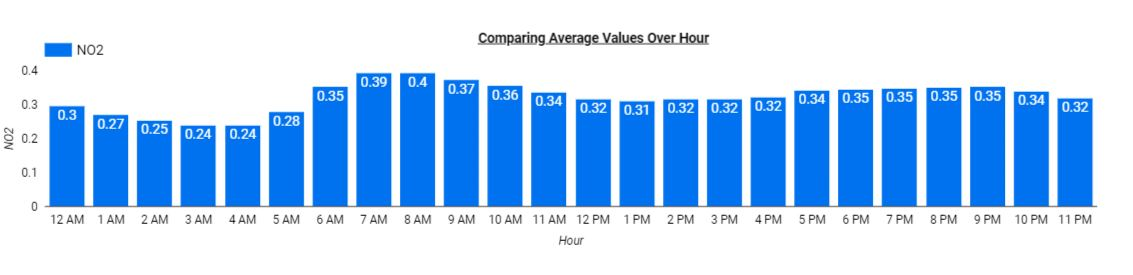

## Correlation Analysis between Weather Data and the Air Quality Data

### Group by the pivoted data by day

To be able to do the correlation analysis, we had to group by each day the pivoted air quality data since the weather data only had daily data. 

In [132]:
pivot_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70843 entries, 0 to 70842
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date_time  70843 non-null  datetime64[ns, UTC]
 1   C6H6       70843 non-null  float64            
 2   C7H8       70843 non-null  float64            
 3   C8H10      70843 non-null  float64            
 4   FN         70843 non-null  float64            
 5   NO         70843 non-null  float64            
 6   NO2        70843 non-null  float64            
 7   PM10       70843 non-null  float64            
 8   PM25       70843 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(8)
memory usage: 4.9 MB


In [133]:
pivot_air_quality = pivot_air_quality.groupby(pd.Grouper(key='date_time',axis=0,freq='D')).sum()

In [134]:
pivot_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2969 entries, 2014-01-01 00:00:00+00:00 to 2022-02-16 00:00:00+00:00
Freq: D
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C6H6    2969 non-null   float64
 1   C7H8    2969 non-null   float64
 2   C8H10   2969 non-null   float64
 3   FN      2969 non-null   float64
 4   NO      2969 non-null   float64
 5   NO2     2969 non-null   float64
 6   PM10    2969 non-null   float64
 7   PM25    2969 non-null   float64
dtypes: float64(8)
memory usage: 208.8 KB


### Inner join air_quality and weather data

Afterwards, we had to join or merge the data air quality data with the weather data. We did this by doing an inner join on the dates. An inner join made more sense since we wanted to pair the same dates from both datasets.

In [144]:
pivot_air_quality = pivot_air_quality.reset_index()

In [145]:
# Change column name "timestamp_measured" to "date" 
pivot_air_quality = pivot_air_quality.rename(columns={"date_time":"date"})

In [141]:
weather['date'] = pd.to_datetime(weather['date'], utc = True)

In [146]:
air_quality_weather = pd.merge(pivot_air_quality, weather, on='date')

### Creating Correlation Matrix

Using the merged data, we created a correlation matrix.

From the correlation matrix we found out that the wind speed has a weak negative correlation with the pollutants FN and NO2. 

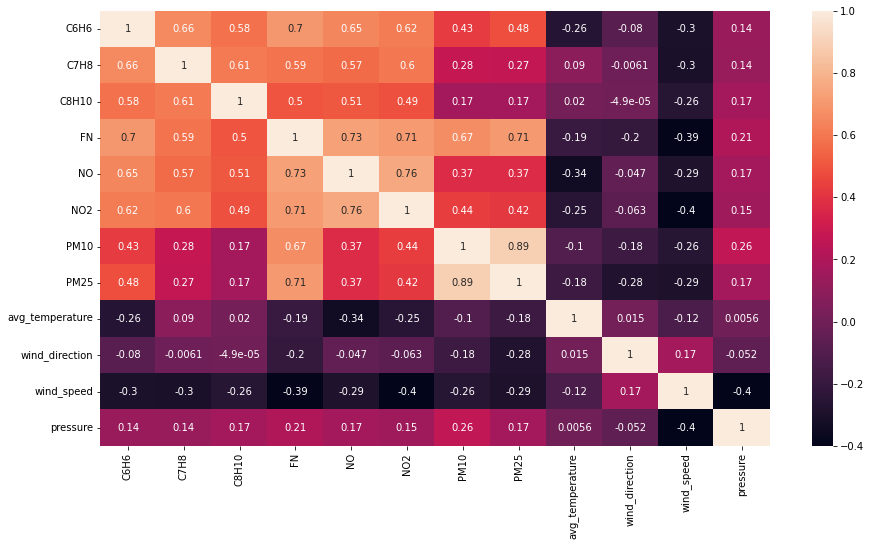

In [147]:
corrMatrix = air_quality_weather.corr()
plt.figure(figsize = (15,8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [2]:
clean_df = pd.read_csv('air_quality_data_cleaned.csv')

# Modeling   
**Objectives:**  
From previous EDA, we find out that Toluene(C7H8), is the only pollutant which is still above safe level in 2022, despite decreasing the most drastically (71%). In this regard, we will utilize ML to predict its future amounnt. Specifically, 3 days data/ 72 steps in order to create a 3-day warning system.  

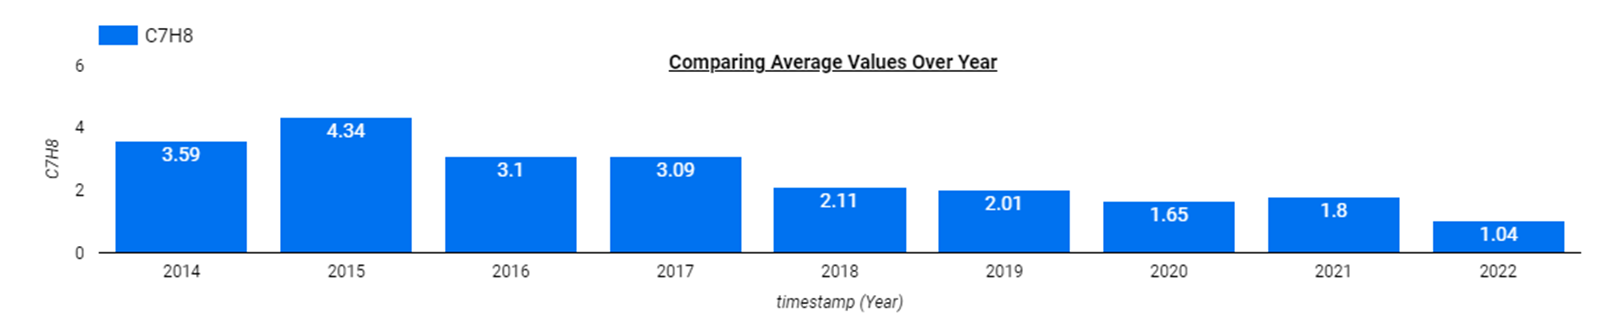

## Auto ARIMA - time series model track
Part A - Preparation 
1. Convert timestamp into datatime object 
2. Fill nans  
3. Convert into a time series  

Part B
1. Understand Stationarity  
2. Understand Sesonality
3. ARIMA model?
4. Examine auto correlation coefficients 
5. Split train test data
6. Choose model order by LLR test and Examining residuals
7. Evaluate model performance - MAPE & RMSE  
8. Predict & Visualize model performance  

**From this section onwards to prediction, we will only use<code>C7H8</code> as the focus.**

### Part A - Preparation
#### 1. Convert into datetime object  
We converted the <code>timestamp</code> column to a datetime object.  
At the same time, we would have a brief look at the data.  
* data ranges from 2014-01-01 12AM to 2022-02-16 10PM
* data are recorded every hour, resulting in 70843 rows

In [3]:
air_quality_ts = clean_df.copy()
air_quality_ts['timestamp'] = pd.to_datetime(air_quality_ts.timestamp, dayfirst=True)
air_quality_ts.timestamp.describe(datetime_is_numeric=True)

count                                  70843
mean     2018-01-28 12:01:38.126843904+00:00
min                2014-01-01 00:00:00+00:00
25%                2016-01-20 15:30:00+00:00
50%                2018-02-01 00:00:00+00:00
75%                2020-02-09 21:30:00+00:00
max                2022-02-16 22:00:00+00:00
Name: timestamp, dtype: object

#### 2. Fill nans
Filling nans for this time series is tricky, because there are lots of consecutive nan data points.  
For instance, there are 19 consecutive nans in NO and NO2. There are even more than 3 quarters of the 2014 data missing for C8H10. 

In [126]:
#air_quality_ts.C8H10.plot(figsize=(20,5), title='C8H10')

luckily for our focus <code>C7H8</code>, nans are more decentralized:

<AxesSubplot:title={'center':'C7H8'}>

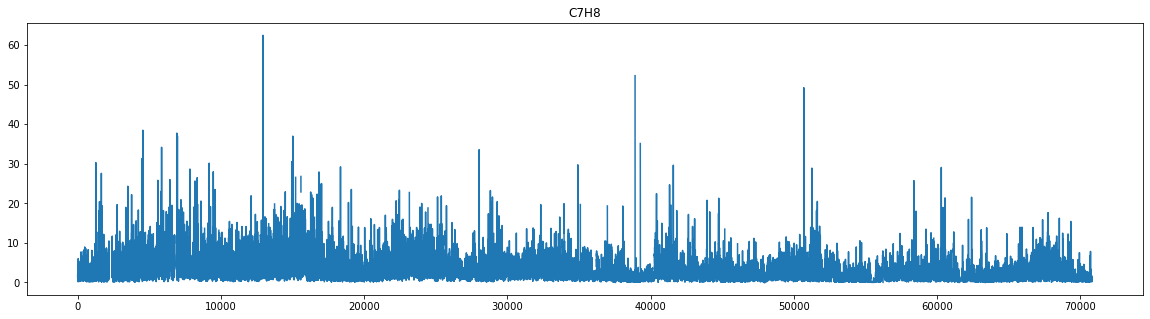

In [5]:
air_quality_ts.C7H8.plot(figsize=(20,5), title='C7H8')

And let's look at the summary of the nans of the columns.  
We can see that <code>C7H8</code>'s nans percentages are 7%, while C8H10's is 20%, and the other 6 pollutants' range from 1% to 3%

In [6]:
def ts_nans(df, length):
    return pd.DataFrame({'number of nans': df.isna().sum(), 'percentage': round(df.isna().sum().div(length),2)})

display(ts_nans(air_quality_ts, 70843))

,number of nans,percentage
timestamp,0,0.00
C6H6,5038,0.07
C7H8,5001,0.07
C8H10,14294,0.20
FN,921,0.01
NO,2154,0.03
NO2,1752,0.02
PM10,1606,0.02
PM25,2319,0.03


In [7]:
air_quality_ts

,timestamp,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25
0,2014-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,27.0,43.0,NaN,NaN
1,2014-01-01 01:00:00+00:00,1.21,1.41,NaN,2.38,30.0,42.0,90.3,74.7
2,2014-01-01 02:00:00+00:00,0.97,1.65,NaN,2.55,28.0,50.0,97.3,84.0
3,2014-01-01 03:00:00+00:00,1.11,1.98,NaN,2.50,24.0,48.0,41.6,34.7
4,2014-01-01 04:00:00+00:00,1.04,2.31,NaN,2.18,19.0,45.0,28.1,20.6
...,...,...,...,...,...,...,...,...,...
70838,2022-02-16 18:00:00+00:00,0.39,1.10,0.71,0.48,7.1,17.7,11.5,10.5
70839,2022-02-16 19:00:00+00:00,0.33,0.98,0.62,0.37,6.5,16.8,10.7,6.5
70840,2022-02-16 20:00:00+00:00,0.26,0.56,0.36,0.29,4.2,14.8,7.6,7.5
70841,2022-02-16 21:00:00+00:00,0.18,0.35,0.23,0.20,3.0,11.2,5.8,7.9


Then, we will fill nans with moving average of 0.5 year because of the presence of extreme values.

In [8]:
C7H8 = air_quality_ts.loc[:, ['timestamp', 'C7H8']]
C7H8['C7H8'] = air_quality_ts.C7H8.fillna(air_quality_ts.C7H8.rolling(window=180, min_periods=1).mean())
C7H8.loc[0, 'C7H8'] = C7H8.loc[1, 'C7H8']

#### 3. Convert into a time series 
now the <code>timestamp</code> column is set as the index and the frequency is set. Let's have a look at our time series. Notice that *'ffill'* is used instead of *'bfill"* to avoid data leakage from the usage of future's data.

In [9]:
C7H8_ts = C7H8.copy()
C7H8_ts.set_index('timestamp', inplace=True)
C7H8_ts = C7H8_ts.asfreq("h", method='ffill')
display(C7H8_ts)

,C7H8
timestamp,
2014-01-01 00:00:00+00:00,1.41
2014-01-01 01:00:00+00:00,1.41
2014-01-01 02:00:00+00:00,1.65
2014-01-01 03:00:00+00:00,1.98
2014-01-01 04:00:00+00:00,2.31
...,...
2022-02-16 18:00:00+00:00,1.10
2022-02-16 19:00:00+00:00,0.98
2022-02-16 20:00:00+00:00,0.56


In [10]:
C7H8_ts.to_csv('C7H8_imp.csv')

### Part B
#### 1. Understand Stationarity
A stationary time series has no trends/ seasonality (not dependent on time). Mathematically, stationary data has constant mean and variance. We want stationary data when using time series models for easier forecasting.  

The data looks very much like white noise, a type of stationary time series from previous visualizations. But we will use two method for confirmation.  
1. Augmented Dickey–Fuller test (ADF) to confirm its stationarity. It tests the null hypothesis that data is non-stationary.  
In other words, we want 
* <code>p-value</code> less than <code>0.05</code>,  
* the absolute value of <code>test statistic</code> greater than the <code>critical values</code> for declaring statistical significance,

to reject null hypothesis and confirm that our time series is stationary.

The function will return the following information:
* **test statistic**: magnitude should be greater than critical values to declare statistical significance
* **p-value**: when p-value < 0.05, we confirm that data is stationary
* no. of lags: 
* no. of obesrvations: no. of lags + no. of obesrvations = length of data
* **critical values**: boundary of rejection region
* maximized information criterion: the lower, the easier to make predictions  

We can see that the test statistic's magnitude is 16.18, way higher than the 1% critical values is 3.43.  
It means that we are 99% confident that we do not get the 0 p-value by random chance.

In [11]:
def adfuller(df, col):
    display(col)
    pd.set_option('display.max_colwidth', True)
    explanations = ['test statistic', 'p-value - chance of non-stationary data', 'no. of lags used', 'no. of observations', 
                      'critical values dict', 'maximized information criterion']
    return pd.DataFrame(zip(explanations, statstool.adfuller(df[col])))

adfuller(C7H8_ts, 'C7H8')

'C7H8'

,0,1
0,test statistic,-16.189356
1,p-value - chance of non-stationary data,0.0
2,no. of lags used,62
3,no. of observations,71192
4,critical values dict,"{'1%': -3.430441857734023, '5%': -2.8615805994982706, '10%': -2.566791609723799}"
5,maximized information criterion,270355.160058


2. constant mean and variance  
the best way to check if the data has a constant variance or not, is to plot the residuals after fitting. Hence we will perform it later. For now, we have defined a function first.

In [12]:
def mean_var_sd(df, col):
    mean = round(df[col].mean(), 3) 
    variance = round(df[col].var(), 3)
    SD = round(np.sqrt(variance), 3)
    print("mean: "+str(mean))
    print("variance: "+str(variance))
    print("SD: "+str(SD))
    return mean, variance, SD

#### 2. Understand Seasonality  
Seasonality is the cyclic behaviour of the data. If it presents, it is better to use data from a cycle before as predictor.  
We will use two method to understand seasonality.
1. Decomposition  
$$observed = trends + seasonality + residuals $$ , (or * for multiplicative)  
the magnitude of seasonality is slighly higher than 1. This indicates that seasonality presents, but is weak .  
On the other hand, notice that the magnitude of trend oscilates between 0 and 20, indicating the presence of trend.

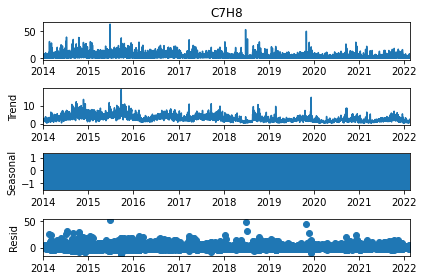

In [13]:
def seasonality(df, col):
    decom_add = seasonal_decompose(df[col], model = 'additive')
    decom_add.plot()
    plt.show()

seasonality(C7H8_ts, "C7H8")

2. Smoothing with moving average  
The moving average smooths out trends by filtering out the noise from random short-term fluctuations. The average is taken over a specific period of time, also called the "window".  
We can see that cyclic behavious and the trends are more visible after smoothing. This would be useful later when we build another model with traditional ML method.

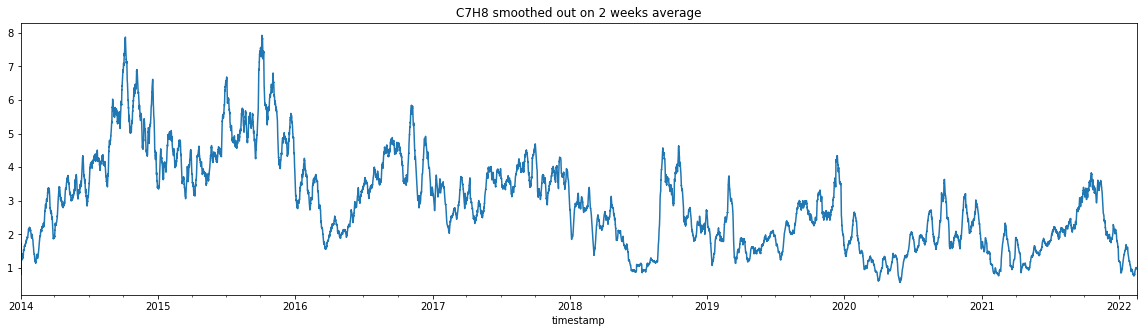

None

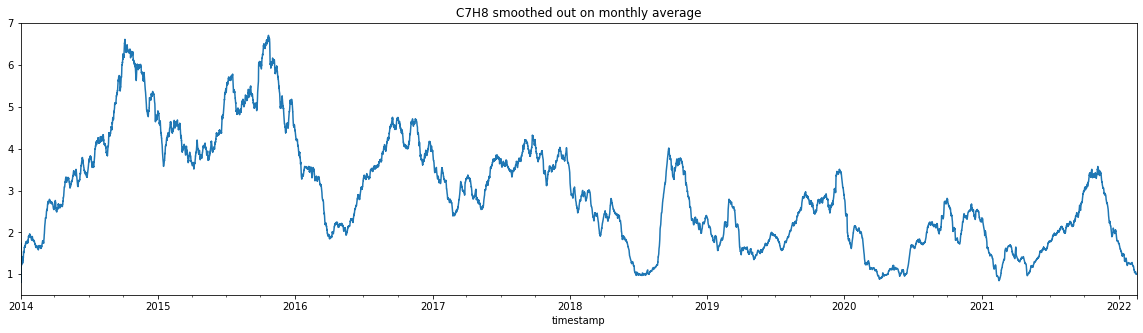

None

In [14]:
def MA(df, col1, col2=None, window=24, remark=None):
    series = df[col1].rolling(window=window, min_periods=1).mean()
    series.plot(figsize=(20, 5))
    if col2 != None:
        series2 = df[col2].rolling(window=window, min_periods=1).mean()
        series2.plot(figsize=(20, 5))
    if remark!=None:
        plt.title(col1+" smoothed out on "+remark)
    else:
        plt.title(col1+" smoothed out on "+str(window)+"steps average")
    plt.show()
    
#display(MA(C7H8_ts, 'C7H8', remark='daily average'))
#display(MA(C7H8_ts, 'C7H8', window=24*7, remark="weekly average"))
display(MA(C7H8_ts, 'C7H8', window=24*14, remark="2 weeks average"))
display(MA(C7H8_ts, 'C7H8', window=24*30, remark='monthly average'))

#### 3. ARIMA model?  
The **Autoregressive Integrated Moving Average(ARIMA)** model is composed of **Auto Regression(AR)**, **Integration**, and **Moving Average(MA)** model. Let's understand what does each part do:  
1. **Auto Regression(AR)** model  
This model relies on past values for predictions with the formular $$ x_{t} = C +  \sum \phi_{i}*x_{t-i} + \epsilon_{t}, where -1 < \phi_{i} < 1$$  
It means that the current period (predicted) value $x_{t}$, is a result of certain constant $C$,  
plus the summation of numeric coefficients times values of the last period $\sum \phi_{i}*x_{t-i}$,  
plus the residuals of current period $\epsilon_{t}$,  
which is calculated by last period's actual values minus last period's predicted values$\epsilon_{t} = y_{t-1, actual} - y_{t-1, predicted}$  

2. **Moving Average(MA)** model:  
This model accounts for very short-run autocorrelation and adapts to shocks well. The formular for the model is $$ y_{t} = c +  \sum \theta_{i}*\epsilon_{t-i} + \epsilon_{t}, where -1 < \theta_{i} < 1 $$
Notice that instead of $\phi_{i}*x_{t-i}$ in an AR model, an MA model has $\theta_{i}*\epsilon_{t-i}$.   
As the model relies on residuals of the last period instead of past values for predictions, it could learn from the result of its own prediction and adjust accordingly.

3. **Integration**  
Earlier we have mentioned that stationarity is essential in a time series model. When the time series is not stationary, integration comes into play. Basically, the first differencing value is the difference between the current time period and the previous time period. If it fails to revolve around a constant mean and variance (requirement of stationarity), a second differencing using the values of the first differencing is needed. This process is repeated until a stationary series is created. The **d** parameter is hence the number of times needed for differencing the series to make it stationary.

The parameter of the model, ***order(p , d, q)***, hence means:
* p: **AR** component - number of lag observations included in the model
* d: **I** component - number of times the raw observations are differenced
* q: **MA** component - size of the moving average window  

But how do we determine *order(p , d, q)*? We examine the plots of the autocorrelation coefficients in the next section.

#### 4. Examine auto correlation coefficients  
An **ACF(Auto Correlation Function)** shows the indirect and direct correlation between the original series and its lag.  
In contrast, a **PACF(Partial Auto Correlation Function)** only shows the direct correlation.     

We use AR terms in model when
* ACF autocorrelation decaying towards zero
* PACF cuts off quickly towards zero at lag n (we will then use n as *p*)
* ACF of a stationary series shows positive at lag 1  

We use MA terms in model when  
* Negative autocorrelation coefficient at lag 1
* ACF drops sharply after a few lags
* PACF decreases more gradually

For a specific number of lags to be significant,   
* the coefficient should exceed blue area (default 95% confidence interval), or they may just be statistical fluke    
  
ACF:  
First we observe the 40lags plot - the correlation coefficients decrease generally till lag 12, then increase generally, peaking at lag 24 (0.48).  
Is it a sign of seasonality? We onserve the 60lags plot and confirm that seasonality presents.  
24 time steps equal to 1 day. It could indicate that a certain hour during the day releases the most <code>C7H8</code>. We suspect that it could be due to busy traffic during peak hours.

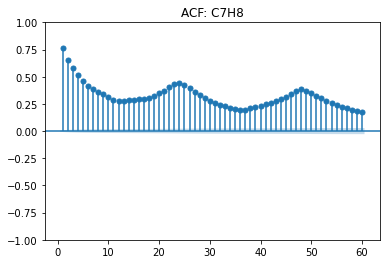

None

In [15]:
def ACF(df, col, lags=40, ylim=1):
    tsaplots.plot_acf(df[col], adjusted=True, zero=False, lags=lags,)
    plt.title("ACF: "+col)
    plt.ylim(top=ylim,bottom=ylim*-1)
    plt.show()

#display(ACF(C7H8_ts, 'C7H8'))
display(ACF(C7H8_ts, 'C7H8', lags=60))

PACF:  
we can see that the coefficients cut off towsrd zero at lag 1 and 2. We will hence try both *p=1* and *p=2*.

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


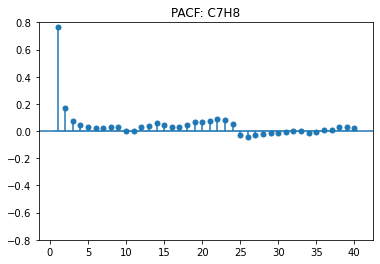

None

In [16]:
def PACF(df, col, lags=40, ylim=1):
    tsaplots.plot_pacf(df[col], zero=False, lags=lags)
    plt.title("PACF: "+col)
    plt.ylim(top=ylim,bottom=ylim*-1)
    plt.show()

display(PACF(C7H8_ts, 'C7H8', ylim=0.8))

Do we need a MA term? Yes definitely, given that there are shocks within C7H8 data.

<AxesSubplot:title={'center':'C7H8'}, xlabel='timestamp'>

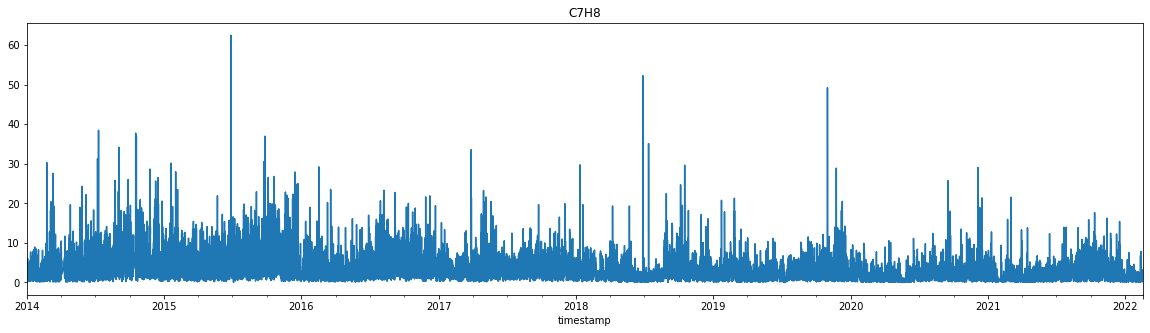

In [17]:
C7H8_ts.C7H8.plot(figsize=(20,5), title='C7H8')

#### 5. Split train test data  
We split 80% data for training, and the remaining for testing.

In [18]:
def split(df, col, percentage=0.8):
    size = int(len(df[col])*percentage)
    train = df[col].iloc[:size]
    test = df[col].iloc[size:]
    return train, test

trainC7H8 = split(C7H8_ts, 'C7H8')[0] 
testC7H8 = split(C7H8_ts, 'C7H8')[1]

In [19]:
display(trainC7H8.tail())
display(testC7H8.head())

timestamp
2020-07-02 23:00:00+00:00    1.25
2020-07-03 00:00:00+00:00    0.96
2020-07-03 01:00:00+00:00    1.25
2020-07-03 02:00:00+00:00    0.93
2020-07-03 03:00:00+00:00    0.94
Freq: H, Name: C7H8, dtype: float64

timestamp
2020-07-03 04:00:00+00:00    0.83
2020-07-03 05:00:00+00:00    0.71
2020-07-03 06:00:00+00:00    1.49
2020-07-03 07:00:00+00:00    1.24
2020-07-03 08:00:00+00:00    1.80
Freq: H, Name: C7H8, dtype: float64

#### 6. Choose model order
##### LLR Test
When choosing the order of model, we want one with maximum log-likelihood and minimum information criterion.
That's when the **LLR Log-Likelihood Ratio Test** comes into play. It helps us to answer the following question:  
*More complex model usually results in higher log-likelihood, but is the diffrence statistically significant?*  

To put it simply, when the <code>p_value</code> returned is less than 0.05, it means that the model can go more complex.  
When using this function, remeber to input the less complex model as <code>mod1</code> and the more complex model as <code>mod2</code> 

In [20]:
def LLR_test(mod1, mod2, DF=1):
    llf1 = mod1.fit().llf
    llf2 = mod2.fit().llf
    LR = 2*(llf2-llf1)
    p_value = round(chi2.sf(LR, DF), 4)
    return p_value

On the other hand, when fitting more complex models and looking at its summary. We are looking for 
* <code>coef</code>: it equals to $\theta_{i}$, which is between -1 and +1. Does the more complex model has a <code>coef</code> greater in magnitude?
* <code>P>|z|</code>: Does the more complex model has a lower<code>P>|z|</code>, or does it remain <code>0.0</code>?  

Let's look at ARIMA(1,1,1) and ARIMA(1,1,2) first.  
ARIMA(1,1,2) has higher likelihood and lower information criterion. But let's use the LLR test to confirm if it's really better.

In [ ]:
PM25_111arima = ARIMA(trainPM25, order=(1,1,1))
PM25_fit_111arima = PM25_111arima.fit()
#display(PM25_fit_111arima.summary())

In [ ]:
PM25_112arima = ARIMA(trainPM25, order=(1,1,2))
PM25_fit_112arima = PM25_112arima.fit()
#display(PM25_fit_112arima.summary())

display(LLR_test(PM25_111arima, PM25_112arima))

The result is 0.0, meaning that ARIMA(1,1,2) is indeed better.  
This process will be repeated until the model with higher *q* fails the test. We will then perform the same test on *p* and *d*.  

However, manual testing is too time consuming. We will therefore use **Auto ARIMA** to automate the testing. An additional parameter *m* is needed. The period for seasonal differencing, *m* refers to the number of periods in each season. For example, *m* is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data.  

*Though I tried modelling m=24 to match the seasonality seen in ACF plots, an error yield and we cannot solve it within the timeframe.*

In [ ]:
def step_autoARIMA(df, m, max_dur=15):
    with StepwiseContext(max_dur=max_dur):
        model = pm.auto_arima(df, stepwise=True, error_action='ignore', seasonal=True, m=m)
    return model

m5 = step_autoARIMA(trainC7H8, 5)
m6 = step_autoARIMA(trainC7H8, 6)
m7 = step_autoARIMA(trainC7H8, 7)

In the following plots, we have a brief look into how the model performs:

Text(0.5, 1.0, 'Test samples vs. forecasts (m=7)')

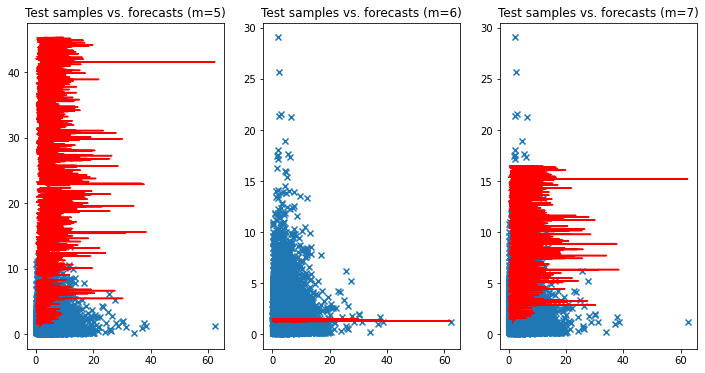

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

leng = len(testC7H8)
axes[0].scatter(trainC7H8[:leng], testC7H8, marker='x')
axes[0].plot(trainC7H8[:leng], m5.predict(n_periods=testC7H8.shape[0]), "r-")
axes[0].set_title('Test samples vs. forecasts (m=5)')
axes[1].scatter(trainC7H8[:leng], testC7H8, marker='x')
axes[1].plot(trainC7H8[:leng], m6.predict(n_periods=testC7H8.shape[0]), "r-")
axes[1].set_title('Test samples vs. forecasts (m=6)')
axes[2].scatter(trainC7H8[:leng], testC7H8, marker='x')
axes[2].plot(trainC7H8[:leng], m7.predict(n_periods=testC7H8.shape[0]), "r-")
axes[2].set_title('Test samples vs. forecasts (m=7)')

#### 7. Evaluate model performance  
##### MAPE (mean absolute percentage error)  
MAPE is the proportion of the average absolute difference between projected and true values divided by the true value. The model is better if the MAPE is low. It works better with data that is free of zeros and extreme values because of the in-denominator.

##### RMSE (root mean squared error)
Like MAPE, the model is better if the RMSE is low. This measure is defined as the square root of mean square error, in other words the magnitude of the error.  

Now let's see how our model performs metrics-wise: m5 model performs the best with least MAPE and RMSE. In other words, the optimum number periods per season is 5.

In [31]:
def MAPE_RMSE(actual, predicted):
    mape = np.mean(np.abs((actual - predicted)/actual))*100
    rmse = mean_squared_error(actual, predicted, squared=False)  # False -> square rooted
    print("MAPE: "+str(mape))
    print("RMSE: "+str(rmse))
    print('\n')

#m5_eval = MAPE_RMSE(testC7H8, m5.predict(n_periods=testC7H8.shape[0]))
m6_eval = MAPE_RMSE(testC7H8, m6.predict(n_periods=testC7H8.shape[0]))
#m7_eval = MAPE_RMSE(testC7H8, m7.predict(n_periods=testC7H8.shape[0]))

MAPE: 108.87893418022901
RMSE: 1.8868827786703593




Let's see what 'm6' is:  
So the best parameters are as follows!

In [32]:
m6

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 6),
      suppress_warnings=True)

#### 8. Predict & Visualize model performance 
##### Examine Prediction vs Actual values
we will use a graph to visualize the model's performance. Since we already know that the data is highly irregularly rough, we will examine by the moving average the extract insights.  

<AxesSubplot:title={'center':'actual vs Auoto ARIMA m6 predictions'}, xlabel='timestamp'>

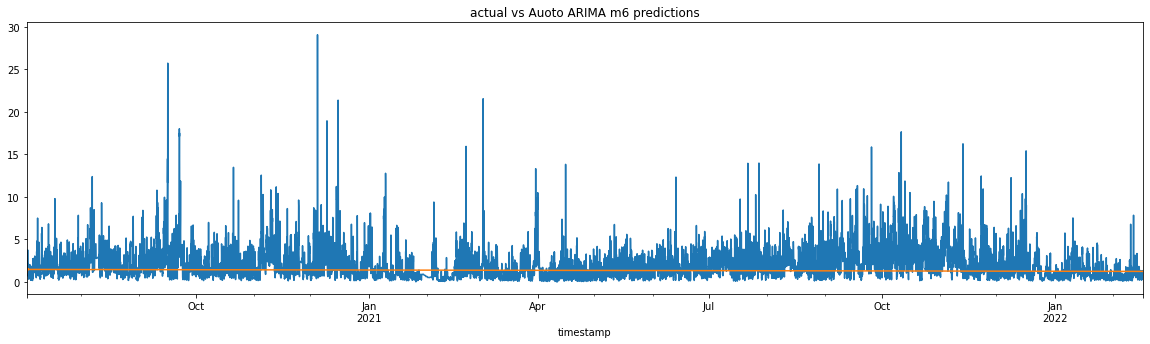

In [33]:
predictions = pd.DataFrame()
predictions['actual'] = testC7H8
predictions['pred_m6'] =  m6.predict(n_periods=testC7H8.shape[0])

predictions.actual.plot(figsize=(20,5), title='actual vs Auoto ARIMA m6 predictions')
predictions.pred_m6.plot(figsize=(20,5))

##### Examine Residuals
we will examine the residuals by the mean and standard deviation.
The largest possible %, by which our prediction is off, is $SD*3$ according to the 68–95–99.7 rule.  

1. check if residuals fulfill constant 0 mean and constant variance requirement (within function)  
2. plot residuals (within function)  
3. compare the ACF plots of different models' residuals  

mean: 0.607
variance: 3.192
SD: 1.787
worst case scnerio: 5.361% off when predicting


None

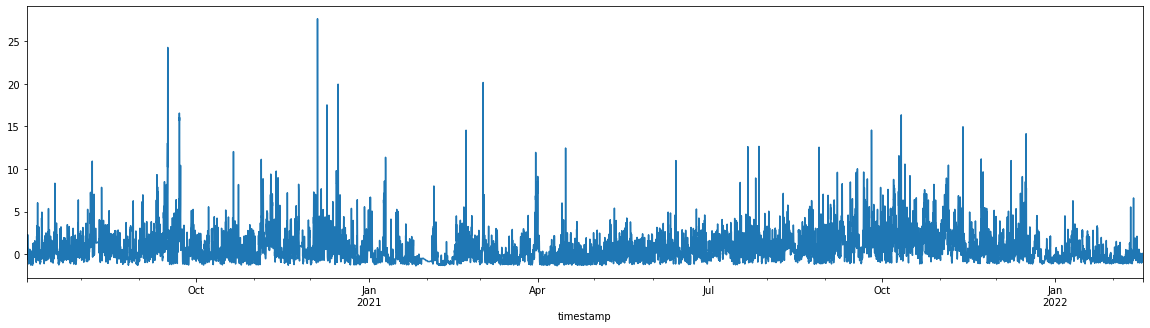

In [34]:
res = pd.DataFrame()
res['res_m6'] = testC7H8 - predictions['pred_m6']
def res_performance(df, col):
    # 1. check if residuals fulfill constant 0 mean and constant variance requirement
    SD = mean_var_sd(df, col)[2]
    print('worst case scnerio: ' + str(round((3*SD),3)) + '% off when predicting')  
    
    # 2. plot residuals   
    df[col].plot(figsize=(20,5))

display(res_performance(res, 'res_m6'))

Now we will plot the ACF for the residuals. To indicate a good model performance:
* coefficients should be insignificant (within the blue area).  
why? *PM25 has a decreasing coefficients in its ACF graph, indicating that past values' effect on current values decrease as time period increase. A good model should hence also put less emphasis on values from farther back*
* coefficients should be around 0 to indicate minimum residuals  

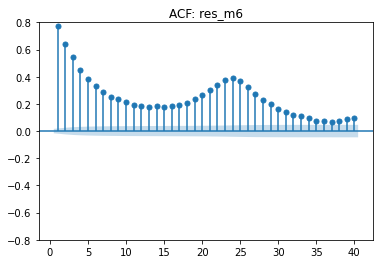

None

In [35]:
display(ACF(res, 'res_m6', ylim=0.8))

As we can see, the Auto ARIMA performs poorly, probably because of the inability to model m=24, the seasonality observed. We will then try another method.

# Modeling - traditional ML model track  
Part A - Preparation 
1. Convert timestamp into datatime object 
2. Extract timestamp as features
3. Convert into a time series  
4. Add other features  
5. Check skewness

Part B
1. XGBoost model?
2. Split train test data
3. Predict and examine the model  
4. Impact metrics measurment

### Part A  
#### 2. Extract timestamp as features  
needed before converting the column into index

In [41]:
def dt_features(df):
    df['day'] = df.timestamp.dt.day
    df['month'] = df.timestamp.dt.month
    df['year'] = df.timestamp.dt.year
    df['day_of_week'] = df.timestamp.dt.dayofweek  # Mon:0, Sun: 6  
    return df

C7H8_fea = dt_features(C7H8)
C7H8_fea.head()

,timestamp,C7H8,day,month,year,day_of_week
0,2014-01-01 00:00:00+00:00,1.41,1,1,2014,2
1,2014-01-01 01:00:00+00:00,1.41,1,1,2014,2
2,2014-01-01 02:00:00+00:00,1.65,1,1,2014,2
3,2014-01-01 03:00:00+00:00,1.98,1,1,2014,2
4,2014-01-01 04:00:00+00:00,2.31,1,1,2014,2


#### 3. Convert into time series (same procedure)  

In [43]:
C7H8_fea_ts = C7H8_fea.copy()
C7H8_fea_ts.set_index('timestamp', inplace=True)
C7H8_fea_ts = C7H8_fea_ts.asfreq("h", method='ffill')
display(C7H8_fea_ts.head())

,C7H8,day,month,year,day_of_week
timestamp,,,,,
2014-01-01 00:00:00+00:00,1.41,1,1,2014,2
2014-01-01 01:00:00+00:00,1.41,1,1,2014,2
2014-01-01 02:00:00+00:00,1.65,1,1,2014,2
2014-01-01 03:00:00+00:00,1.98,1,1,2014,2
2014-01-01 04:00:00+00:00,2.31,1,1,2014,2


#### 4. Add features
##### Weather

In [ ]:
weather_raw = pd.read_csv('cleaned_weather_data_ams.csv')
weather = weather_raw.copy()
weather['date'] = pd.to_datetime(weather.date, dayfirst=True)
weather.set_index('date', inplace=True)
weather = weather.asfreq("h", method='ffill')
weather.head()

We will drop the rows with nans in weather data (46rows in the C7H8 dataframe).

In [ ]:
C7H8weather_ts = pd.concat([C7H8_fea_ts, weather], axis=1)
C7H8weather_ts = C7H8weather_ts.dropna()
display(C7H8weather_ts.head())

We know that the data has shocks from the previous visualizations. In this regard, we will add moving average of pullutants amount as a feature.  
##### weekly moving average of pollutants amount  

As a reminder, this graph from previous section shows is what the new series would look like.

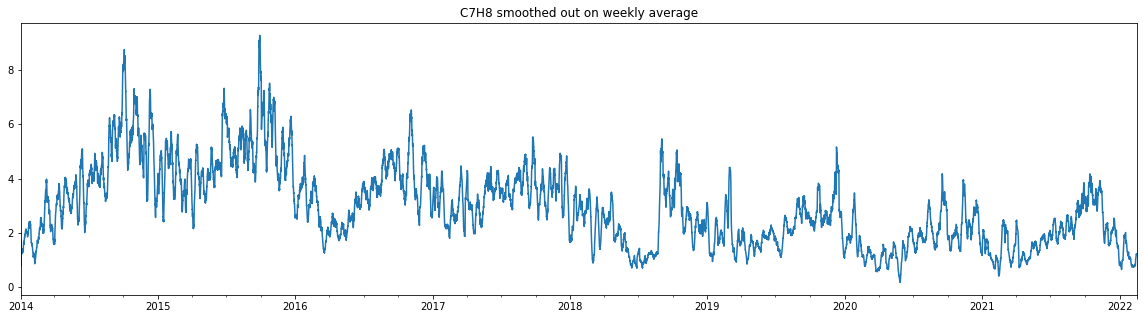

None

,C7H8,day,month,year,day_of_week,avg_temperature,wind_direction,wind_speed,pressure,C7H8_roll
2014-01-01 00:00:00+00:00,1.41,1,1,2014,2,6.5,171.0,28.5,1003.0,1.4100
2014-01-01 01:00:00+00:00,1.41,1,1,2014,2,6.5,171.0,28.5,1003.0,1.4100
2014-01-01 02:00:00+00:00,1.65,1,1,2014,2,6.5,171.0,28.5,1003.0,1.4900
2014-01-01 03:00:00+00:00,1.98,1,1,2014,2,6.5,171.0,28.5,1003.0,1.6125
2014-01-01 04:00:00+00:00,2.31,1,1,2014,2,6.5,171.0,28.5,1003.0,1.7520


In [51]:
display(MA(C7H8weather_ts, 'C7H8', window=24*7, remark="weekly average"))
C7H8weather_ts['C7H8_roll'] = C7H8weather_ts['C7H8'].rolling(window=168, min_periods=1).mean()
C7H8weather_ts.head()

#### 5. Check skewness
We can see that <code>wind speed</code> and <code>C7H8_roll</code> are extremly positive skewed/right-tailed (most of the values are small). Data with more than*0.5* skeness is considered moderately skewed. Hence, we will scale the columns having skewness more than 0.5.

In [71]:
X_all = C7H8weather_ts.drop('C7H8', axis=1)
skewness_df = X_all.apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_cols = skewness_df[skewness_df > 0.5].index
skewness_df

wind_speed         1.023499
C7H8_roll          0.751067
avg_temperature    0.027867
year               0.020309
day                0.012716
month              0.007020
day_of_week        0.000697
wind_direction    -0.314900
pressure          -0.412689
dtype: float64

To make it easier for the model to learn, we will scale these columns.

In [72]:
for col in skewed_cols:
    X_all[col] = boxcox1p(X_all[col], boxcox_normmax(X_all[col] + 1))

#skewness_df = X_all.apply(lambda x: skew(x)).sort_values(ascending=False)

### Part B 
#### 1. XGBoost model 
XGBoost works as Newton Raphson in function space unlike gradient boosting that works as gradient descent in function space, a second order Taylor approximation is used in the loss function to make the connection to Newton Raphson method.  

Due to time limit, I have used a preoptimised parameter for another dataset.

In [99]:
xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460,max_depth=3, min_child_weight=0,gamma=0, 
                   subsample=0.7,colsample_bytree=0.7,objective='reg:squarederror', nthread=-1,
                   scale_pos_weight=1, seed=27,reg_alpha=0.00006)

#### 2. Split train test data

In [118]:
leng = int(len(C7H8weather_ts)*0.8)
X_train = X_all[:leng] 
X_test = X_all[leng:]
train_y = pd.DataFrame(C7H8weather_ts.C7H8[:leng]) 
test_y = pd.DataFrame(C7H8weather_ts.C7H8[leng:])

#### 3. Predict and examine the model

In [119]:
# fit the model to train data
model = xgb.fit(X_train, train_y)
# predict the test data
test_y['predicted'] = model.predict(X_test)

In [120]:
test_y

,C7H8,predicted
2020-07-01 15:00:00+00:00,1.84,1.521771
2020-07-01 16:00:00+00:00,1.60,1.523660
2020-07-01 17:00:00+00:00,2.13,1.523660
2020-07-01 18:00:00+00:00,1.79,1.523660
2020-07-01 19:00:00+00:00,1.47,1.523660
...,...,...
2022-02-14 20:00:00+00:00,0.90,0.938288
2022-02-14 21:00:00+00:00,0.80,0.938288
2022-02-14 22:00:00+00:00,0.87,0.938288
2022-02-14 23:00:00+00:00,0.72,0.938288


Now, we examine its MAPE and RMSE similarly. For your reference, our previous m6 ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 6)) model's evaluation metrics are as follows:  
MAPE: 108.87893418022901  
RMSE: 1.8868827786703593

In [101]:
xgb_eval = MAPE_RMSE(test_y, predicted_y)
xgb_eval

MAPE: 117.19196219589216
RMSE: 1.578545585926916




In other words, the XGBoost model has higher mean absolute percentage error (by around9%), but has lower root mean squared error (by around 0.3). Now let's see how the graph looks like:

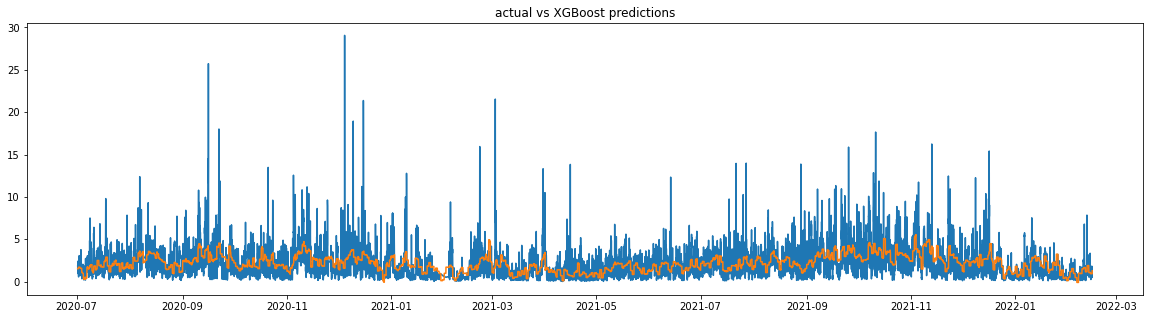

In [125]:
plt.figure(figsize=(20,5))
plt.plot(test_y.C7H8)
plt.plot(test_y['predicted'])
plt.title('actual vs XGBoost predictions')
plt.show()

Compared to Auto ARIMA's straight line prediction, XGBoost is able to predict certain seasonality.  

##### Feature importance  
To explain a model, we could look at which features it has placed importance on.  
From the bar plot below, we discover that year is the most important feature (0.225), followed by the rolling average of the target (0.21), month and wind speed (0.14).

Text(0.5, 1.0, 'XGBRegressor')

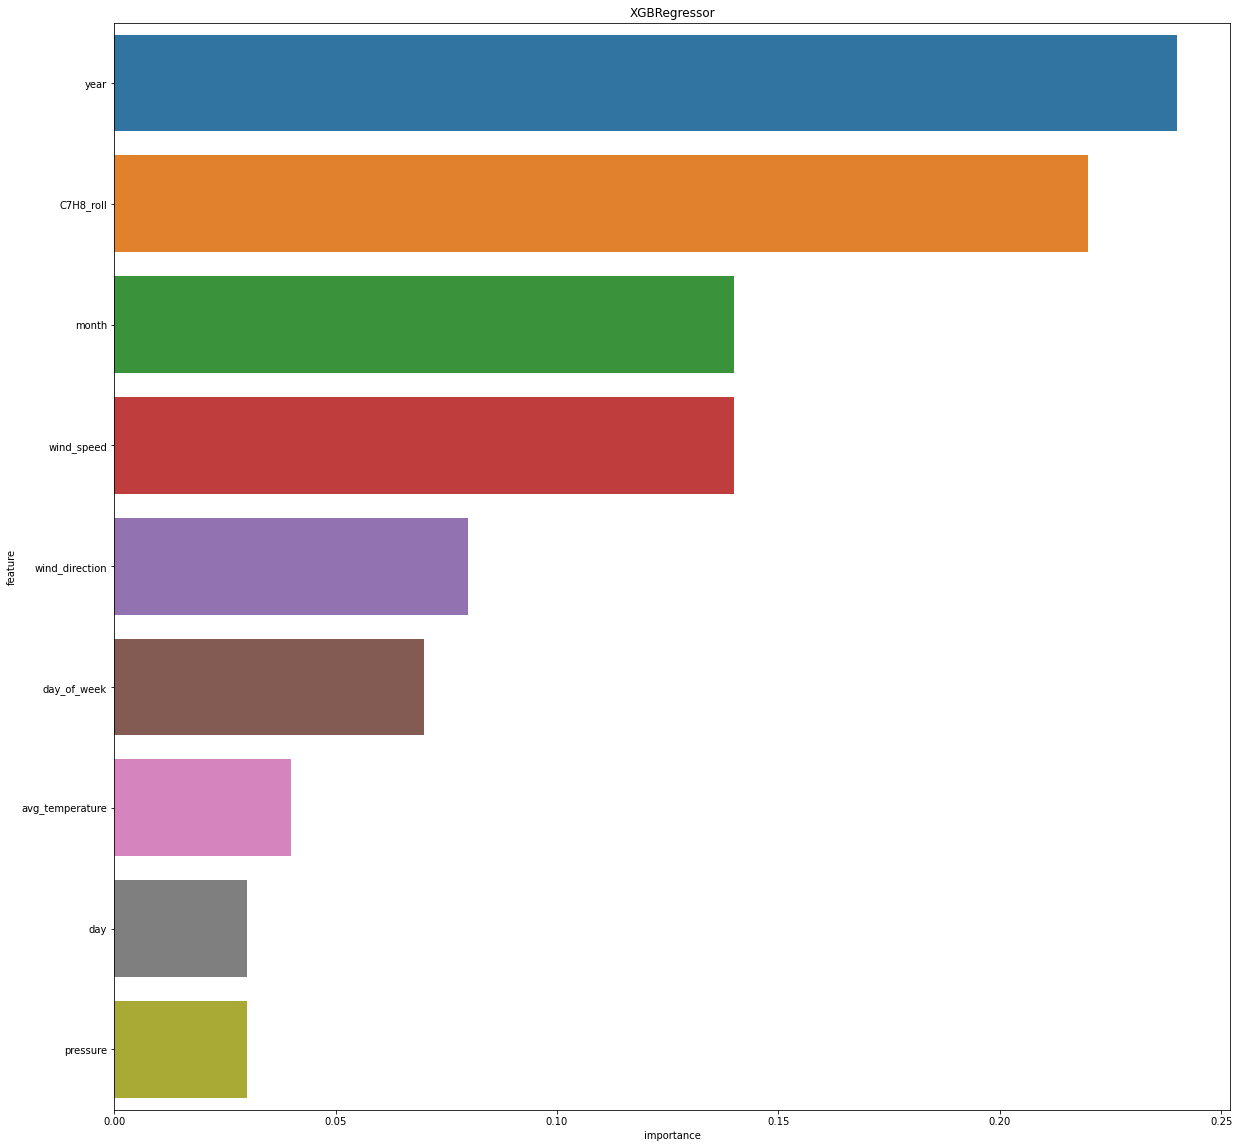

In [141]:
importance_df = pd.DataFrame({"feature": X_train.columns, "importance": np.round(xgb.feature_importances_,2)}).sort_values(by = "importance", ascending = False)
plt.figure(figsize=(20,20))
title = str(xgb).split('(')[0]
sns.barplot(x='importance', y='feature', data=importance_df).set_title(title)

#### 4. Impact metrics measurment
Despite the inaccuracy of the data, we would try meauring its impact
##### Average MAPE(mean absolute persentage error) of the predictions over the week
using the Auto ARIMA model, the MAPE would be 108%
##### Average warnings per week  
instant warning will be sent when the level is beyond safe for 5 hours or more

In [137]:
# get number of weeks in predictions
weeks = int(len(test_y['predicted'])/(24*7))

# 1.1 is the maximum amount of the safe level, so if it goes beyond it, a warning is issued
average_warning = test_y['predicted'].apply(lambda x: 'warning' if x>1.1 else 'no warning')

print('average warning per week: ')
pd.DataFrame(zip(average_warning.value_counts().index, average_warning.value_counts()/(weeks*5))).loc[0, 1]

average warning per week: 


29.266666666666666

# Future Work  
Because of time limits, this project has many room for improvement. It is more ideal if we could
* collect open-source traffic and noise data as features and see if they correlates with the seasonality, given that they are probably the main source of air pollutants
* create  
1. a pollution level and noise map  
2. a pollution level and traffic volumen map, to observe their correlations
* collect data on other streets in Amsterdam to make a comparison between them
* use SARIMA model instead of Auto Arima to better account for the (24 time steps/ daily) seasonality. 
* optimise the XGBoost model used  
* use ensemble method to combine different models for a best performing one

## 🖼️ Visualisations
Link to interactive dashboard: https://datastudio.google.com/reporting/48556ba0-ddbe-4c1e-abbf-c927ad81598c

## 👓 References 
* https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
* https://www.udemy.com/course/time-series-analysis-in-python/  
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=An%20ARIMA%20model%20is%20a,making%20skillful%20time%20series%20forecasts.  
* https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp  
* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/  
* https://www.kaggle.com/code/ryanholbrook/hybrid-models
* https://alkalineml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#:~:text=The%20period%20for%20seasonal%20differencing,Default%20is%201.  
* https://analyticsindiamag.com/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/  
* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/  
* https://syncedreview.com/2017/10/22/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition/

## ⏭️ Appendix